# Exercise 3
Yong Wu</br>
Ziwei Liu</br>
Wenzhuo Chen

## 1 Introduction

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

batch_size = 100

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    if use_cuda:
        w=w.cuda()
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 3.99e-01
Mean Test Loss:  3.05e-01
Epoch: 10
Mean Train Loss: 1.49e-01
Mean Test Loss:  3.63e-01
Epoch: 20
Mean Train Loss: 1.11e-01
Mean Test Loss:  4.51e-01
Epoch: 30
Mean Train Loss: 6.11e-02
Mean Test Loss:  5.31e-01
Epoch: 40
Mean Train Loss: 4.71e-02
Mean Test Loss:  6.84e-01
Epoch: 50
Mean Train Loss: 3.53e-02
Mean Test Loss:  7.83e-01
Epoch: 60
Mean Train Loss: 3.06e-02
Mean Test Loss:  8.18e-01
Epoch: 70
Mean Train Loss: 2.97e-02
Mean Test Loss:  8.49e-01
Epoch: 80
Mean Train Loss: 1.10e-02
Mean Test Loss:  1.01e+00
Epoch: 90
Mean Train Loss: 1.34e-02
Mean Test Loss:  8.43e-01
Epoch: 100
Mean Train Loss: 1.70e-02
Mean Test Loss:  1.02e+00


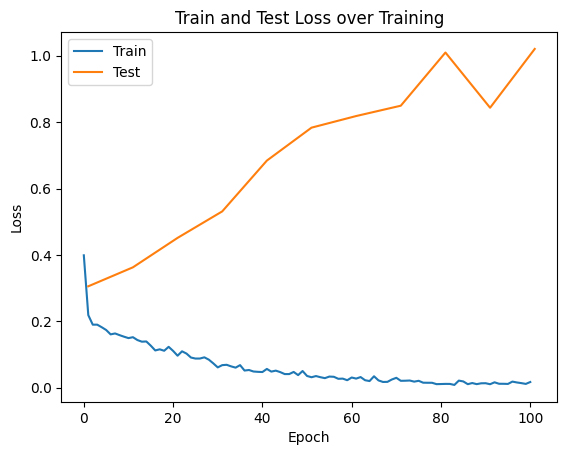

In [16]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x=x.to(device)
        y=y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o).to(device)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x=x.to(device)
                y=y.to(device)
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o).to(device)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


## 2 Dropout

In [2]:
def dropout(X,p_drop=0.5,mode="Training"):
    if mode=="Training":
        if p_drop>0 and p_drop<1:
            X*=torch.tensor(np.abs(np.random.binomial(1, p_drop, size=X.shape)-1)/(1-p_drop),dtype=torch.float32,device=device)
        return X
    else:
        return X

The role of the Dropout layer is a technique to prevent overfitting.It can randomly discard some neurons during the training process, making the network structure more sparse, reducing the complex co-adaptive relationship between parameters, and enhancing the generalization ability of the model.

Because we will randomly discard some neurons during the training process, and they are still fully connected during the test, so we need to multiply the test weight by the (1-P)

From the results, it can be found that the training error of the test set is also decreasing, and the problem of over-fitting has been significantly dealt with.

# 3 Parametric Relu

In [3]:
def PRelu(X,a):
    return torch.where(X <= 0, a * X, X)

From the results, it can be found that the training error of the test set is also decreasing, and the problem of over-fitting has been significantly dealt with.

In [4]:
def drop_model(X,w_h,w_h2,w_o,a_0,a_1,mode,p_drop_input=0.5,p_drop_hidden=0.5):
    h0=dropout(X,p_drop_input,mode)
    h1 = PRelu(h0 @ w_h,a_0)
    h_drop1=dropout(h1,p_drop_hidden,mode)
    h2 = PRelu(h_drop1 @ w_h2,a_1)
    h2_drop = dropout(h2, p_drop_hidden,mode)
    pre_softmax = h2_drop @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 2.99e+00
Mean Test Loss:  5.79e-01
Epoch: 10
Mean Train Loss: 5.74e-01
Mean Test Loss:  1.51e-01
Epoch: 20
Mean Train Loss: 5.34e-01
Mean Test Loss:  1.73e-01
Epoch: 30
Mean Train Loss: 5.24e-01
Mean Test Loss:  1.29e-01
Epoch: 40
Mean Train Loss: 5.07e-01
Mean Test Loss:  1.24e-01
Epoch: 50
Mean Train Loss: 4.96e-01
Mean Test Loss:  1.25e-01
Epoch: 60
Mean Train Loss: 5.07e-01
Mean Test Loss:  1.20e-01
Epoch: 70
Mean Train Loss: 5.06e-01
Mean Test Loss:  1.28e-01
Epoch: 80
Mean Train Loss: 5.09e-01
Mean Test Loss:  1.51e-01
Epoch: 90
Mean Train Loss: 5.07e-01
Mean Test Loss:  1.40e-01
Epoch: 100
Mean Train Loss: 5.38e-01
Mean Test Loss:  1.34e-01


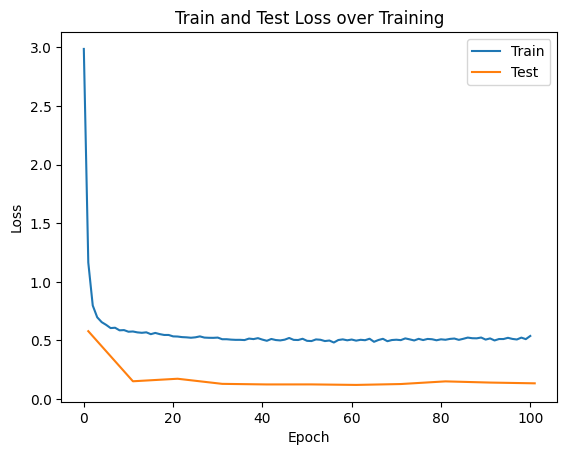

In [5]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# PRelu input layer parameter
a_0=init_weights((1,625))
# PRelu hidden layer parameter
a_1=init_weights((1,625))

optimizer = RMSprop(params=[w_h, w_h2, w_o,a_0,a_1])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x=x.to(device)
        y=y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = drop_model(x, w_h, w_h2, w_o,a_0,a_1,"Training").to(device)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x=x.to(device)
                y=y.to(device)
                x = x.reshape(batch_size, 784)
                noise_py_x = drop_model(x, w_h, w_h2, w_o,a_0,a_1,"Testing").to(device)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# PRelu input layer parameter
a_0=init_weights((100,625))
# PRelu hidden layer parameter
a_1=init_weights((100,625))

optimizer = RMSprop(params=[w_h, w_h2, w_o,a_0,a_1])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x=x.to(device)
        y=y.to(device)

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = drop_model(x, w_h, w_h2, w_o,a_0,a_1,"Training").to(device)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x=x.to(device)
                y=y.to(device)
                x = x.reshape(batch_size, 784)
                noise_py_x = drop_model(x, w_h, w_h2, w_o,a_0,a_1,"Testing").to(device)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## 4 Convolutional layers

### 4.1 Create a Convolutional network

In [6]:
def cnn_model(X,conv_w_1,conv_w_2,conv_w_3,w_h2,w_o,mode,p_drop_hidden=0.5):
    #convolutional laye 1
    conv_layer_1=rectify(conv2d(X,conv_w_1))
    subsampling_layer_1=max_pool2d(conv_layer_1,(2,2))
    out_1=dropout(subsampling_layer_1,p_drop_hidden,mode)

    #convolutional laye 2
    conv_layer_2=rectify(conv2d(out_1,conv_w_2))
    subsampling_layer_2=max_pool2d(conv_layer_2,(2,2))
    out_2=dropout(subsampling_layer_2,p_drop_hidden,mode)

    #convolutional laye 2
    conv_layer_3=rectify(conv2d(out_2,conv_w_3))
    subsampling_layer_3=max_pool2d(conv_layer_3,(2,2))
    out_3=dropout(subsampling_layer_3,p_drop_hidden,mode)

    h1=out_3.reshape(out_3.shape[0],-1)

    h2 = rectify(h1 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 3.62e+00
Mean Test Loss:  1.08e+00
Epoch: 10
Mean Train Loss: 4.67e-01
Mean Test Loss:  3.33e-01
Epoch: 20
Mean Train Loss: 4.41e-01
Mean Test Loss:  2.15e-01
Epoch: 30
Mean Train Loss: 4.57e-01
Mean Test Loss:  2.63e-01
Epoch: 40
Mean Train Loss: 4.86e-01
Mean Test Loss:  2.65e-01
Epoch: 50
Mean Train Loss: 5.47e-01
Mean Test Loss:  2.82e-01
Epoch: 60
Mean Train Loss: 6.31e-01
Mean Test Loss:  4.15e-01
Epoch: 70
Mean Train Loss: 6.95e-01
Mean Test Loss:  4.37e-01
Epoch: 80
Mean Train Loss: 8.04e-01
Mean Test Loss:  4.18e-01
Epoch: 90
Mean Train Loss: 8.76e-01
Mean Test Loss:  7.12e-01
Epoch: 100
Mean Train Loss: 9.62e-01
Mean Test Loss:  4.19e-01


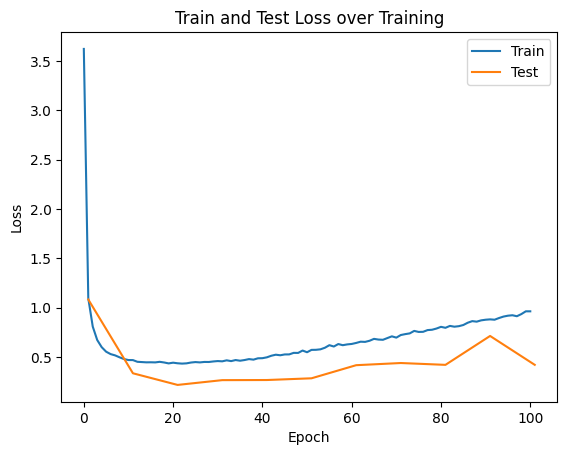

In [7]:
conv_w_1=init_weights((32,1,5,5))
conv_w_2=init_weights((64,32,5,5))
conv_w_3=init_weights((128,64,2,2))

w_h2=init_weights((128,625))
w_o = init_weights((625, 10))

optimizer = RMSprop(params=[conv_w_1,conv_w_2,conv_w_3,w_h2,w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x=x.to(device)
        y=y.to(device)

        # our model requires flattened input
        x = x.reshape(-1,1,28,28 )
        # feed input through model
        noise_py_x = cnn_model(x, conv_w_1,conv_w_2,conv_w_3,w_h2,w_o,"Training").to(device)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x=x.to(device)
                y=y.to(device)
                x =x.reshape(-1,1,28,28 )
                noise_py_x = cnn_model(x, conv_w_1,conv_w_2,conv_w_3,w_h2,w_o,"Testing").to(device)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [37]:
def draw(conv_w_1):
    data_iter =  iter(test_dataloader)
    (image, label) = next(data_iter)
    image=image.cpu()
    label=label.cpu()
    conv_w_1=conv_w_1.cpu()

    img_1 = image[0, 0, :, :].numpy()
    label_1=label[0]

    filter1_py = conv_w_1[1, 0, :, :].detach().numpy()
    filter2_py = conv_w_1[2, 0, :, :].detach().numpy()
    filter3_py = conv_w_1[3, 0, :, :].detach().numpy()

    conv_layer_1 = conv2d(image, conv_w_1)

    img1 = conv_layer_1[0, 1, :, :].detach().numpy()
    img2 = conv_layer_1[0, 2, :, :].detach().numpy()
    img3 = conv_layer_1[0, 3, :, :].detach().numpy()

    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(3, 3, 2)
    ax1.imshow(img_1,cmap='gray')
    ax1.set_title('Picture - Label: {}'.format(label_1))

    ax2 = fig.add_subplot(3, 3, 4)
    ax2.imshow(filter1_py, cmap='gray')
    ax2.set_title('First filter - Label: {}'.format(label_1))

    ax3 = fig.add_subplot(3,3,5)
    ax3.imshow(filter2_py, cmap='gray')
    ax3.set_title('Second filter - Label: {}'.format(label_1))

    ax4 = fig.add_subplot(3,3,6)
    ax4.imshow(filter3_py, cmap='gray')
    ax4.set_title('Third filter - Label: {}'.format(label_1))

    ax5 = fig.add_subplot(3, 3, 7)
    ax5.imshow(img1, cmap='gray')
    ax5.set_title('First filterd output - Label: {}'.format(label_1))

    ax6 = fig.add_subplot(3,3,8)
    ax6.imshow(img2, cmap='gray')
    ax6.set_title('First filterd output - Label: {}'.format(label_1))

    ax7 = fig.add_subplot(3,3,9)
    ax7.imshow(img3, cmap='gray')
    ax7.set_title('Third filterd output - Label: {}'.format(label_1))
    
    fig.tight_layout()

    plt.show()

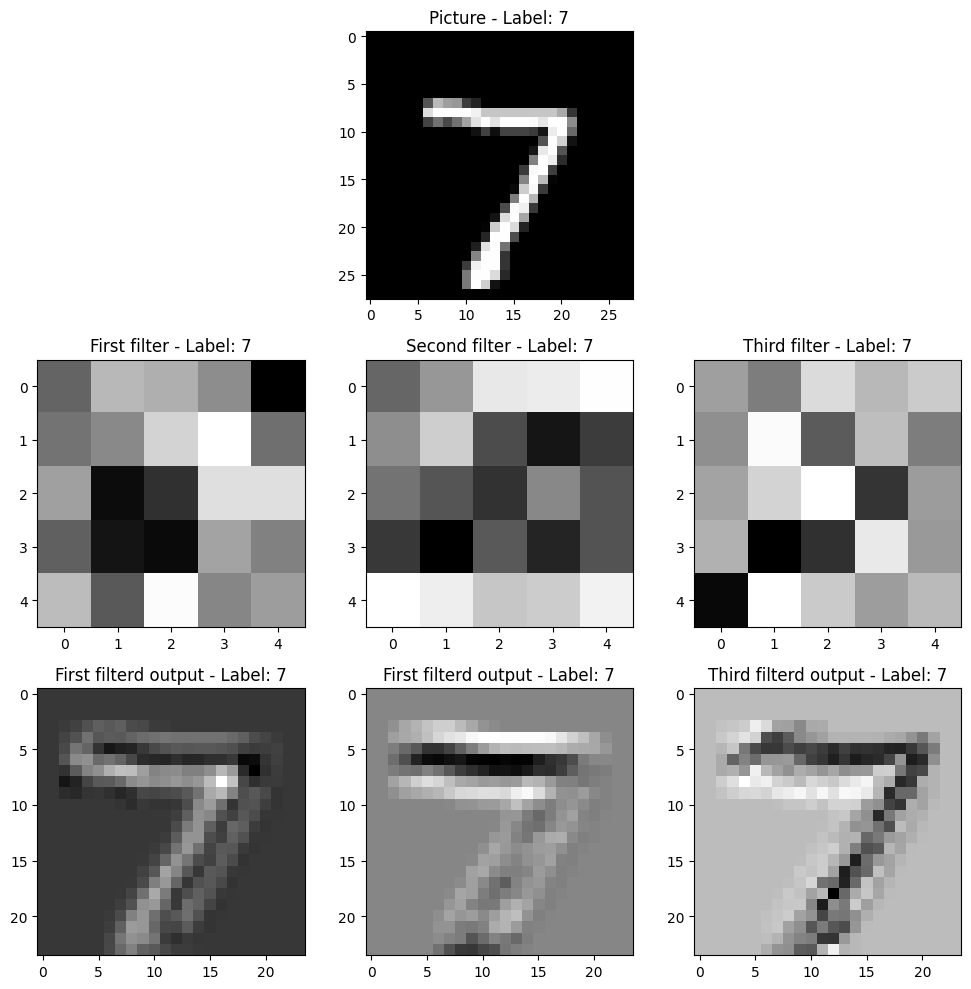

In [38]:
draw(conv_w_1)

### 4.2 Application of Convolutional network

#### 4.2.1 with 2 convolutional layer

In [42]:
def cnn_model_2_layer(X,conv_w_1,conv_w_2,w_h2,w_o,mode,p_drop_hidden=0.5):
    #convolutional laye 1
    conv_layer_1=rectify(conv2d(X,conv_w_1))
    subsampling_layer_1=max_pool2d(conv_layer_1,(2,2))
    out_1=dropout(subsampling_layer_1,p_drop_hidden,mode)

    #convolutional laye 2
    conv_layer_2=rectify(conv2d(out_1,conv_w_2))
    subsampling_layer_2=max_pool2d(conv_layer_2,(2,2))
    out_2=dropout(subsampling_layer_2,p_drop_hidden,mode)

    h1=out_2.reshape(out_2.shape[0],-1)

    h2 = rectify(h1 @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

Epoch: 0
Mean Train Loss: 1.10e+00
Mean Test Loss:  1.74e-01
Epoch: 10
Mean Train Loss: 3.32e-01
Mean Test Loss:  7.60e-01
Epoch: 20
Mean Train Loss: 3.67e-01
Mean Test Loss:  6.39e-01
Epoch: 30
Mean Train Loss: 3.57e-01
Mean Test Loss:  2.42e-01
Epoch: 40
Mean Train Loss: 3.63e-01
Mean Test Loss:  3.29e-01
Epoch: 50
Mean Train Loss: 3.63e-01
Mean Test Loss:  2.25e-01
Epoch: 60
Mean Train Loss: 3.73e-01
Mean Test Loss:  2.87e-01
Epoch: 70
Mean Train Loss: 3.81e-01
Mean Test Loss:  1.20e-01
Epoch: 80
Mean Train Loss: 3.82e-01
Mean Test Loss:  1.34e-01
Epoch: 90
Mean Train Loss: 3.75e-01
Mean Test Loss:  1.08e-01
Epoch: 100
Mean Train Loss: 3.98e-01
Mean Test Loss:  1.38e-01


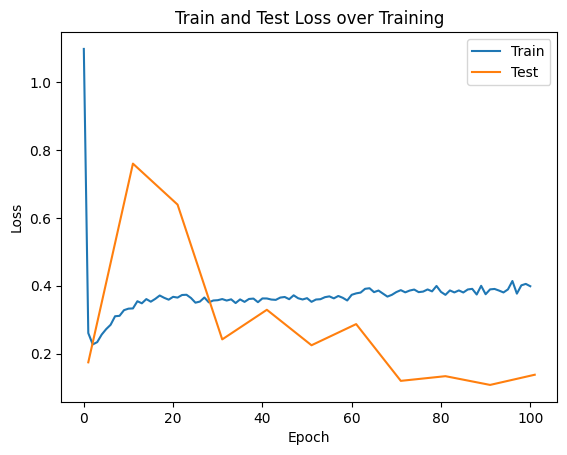

In [43]:
conv_w_1=init_weights((32,1,5,5))
conv_w_2=init_weights((64,32,5,5))

w_h2=init_weights((1024,625))
w_o = init_weights((625, 10))

optimizer = RMSprop(params=[conv_w_1,conv_w_2,w_h2,w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch
        x=x.to(device)
        y=y.to(device)

        # our model requires flattened input
        x = x.reshape(-1,1,28,28 )
        # feed input through model
        noise_py_x = cnn_model_2_layer(x, conv_w_1,conv_w_2,w_h2,w_o,"Training").to(device)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x=x.to(device)
                y=y.to(device)
                x =x.reshape(-1,1,28,28 )
                noise_py_x = cnn_model_2_layer(x, conv_w_1,conv_w_2,w_h2,w_o,"Testing").to(device)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

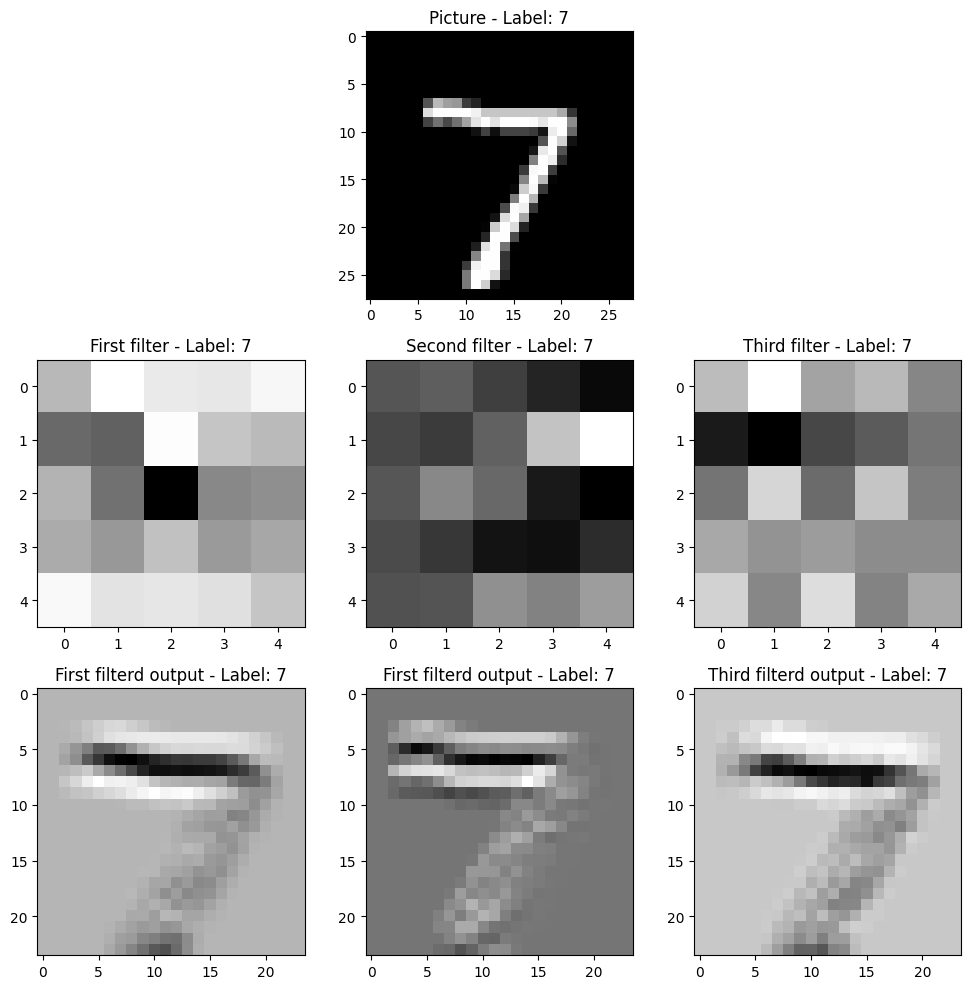

In [44]:
draw(conv_w_1)